[Notebook Popularity &lt;](1_Popularity.ipynb) | [&gt; Notebook Owners](3_Owners.ipynb)

# Programming Languages in Jupyter

Here, we focus only on notebooks that have a specified language to examine what programming languages people are using with Jupyter Notebooks and their growth overt time. 1.79% of notebooks do not have a specified language and are removed before analysis.

## Results Summary:
- Python is consistently the most popular programming language for Jupyter notebooks. There are over 100 times more notebooks written in Python than there are in the next most popular language, R. Julia and R are very close in popularity. Many other languages are used (e.g. Scala, Bash, C++, Ruby), but with minimal frequency. 
    - 98.3% of notebooks have a specified language. Of these, 97.62 % are written in Python, 0.80% Julia, and 0.95% R..
- The relative popularities of languages have not changed much over time.
- It appears that there are very few notebooks written in Python 3.3 and 3.4. However, these versions were released and used frequently from 2012 - 2015, when notebooks were most often in format 2 or 3. Further, nearly all of version 2 and 3 notebooks are missing language versions. It's likely that Python 3.3 and 3.4 were used heavily during these years but are not accounted for in our dataset due to the formats of the notebooks.


--------

# Import Packages & Load Data

In [1]:
import pandas as pd
import numpy as np
import calendar

import matplotlib.pyplot as plt
import load_data
import datetime

In [2]:
repos_temp = load_data.load_repos()
notebooks_temp = load_data.load_notebooks()


Repos loaded in 0:00:04.433827
Notebooks loaded in 0:00:24.465798


--------

# Tidy Data

### Focus in on notebooks with a specified language


In [3]:
notebooks = notebooks_temp.copy()[~notebooks_temp.lang_name.isna()].reset_index(drop=True)

In [4]:
print("{0} ({1}%) of notebooks not in ipynb checkpoints have a specified language. \nThe {2}% without a language have been removed.".format(
    len(notebooks),
    round(100*len(notebooks)/len(notebooks_temp), 2), 
    round(100 - 100*len(notebooks)/len(notebooks_temp), 2)
))

4215016 (98.23%) of notebooks not in ipynb checkpoints have a specified language. 
The 1.77% without a language have been removed.


### Update repos to reflect notebooks with a language

In [5]:
repos = repos_temp.copy()[repos_temp.repo_id.isin(notebooks.repo_id)].reset_index(drop=True)

### Delete temp dataframes to save space

In [6]:
del repos_temp
del notebooks_temp

---

# Visualizations & Statistics
## What programming langugages are the most popular to use with Jupyter notebooks?

In [7]:
counts = notebooks.groupby('lang_name')['file'].count().sort_values(ascending=False).reset_index().rename(
    columns = {'file':'count'}
)

print("{0}% of notebooks with a specified language are written in Python, {1}% Julia, and {2}% R.".format(
    round(100*sum(notebooks.lang_name == 'python') / len(notebooks), 3),
    round(100*sum(notebooks.lang_name == 'julia') / len(notebooks), 3),
    round(100*sum(notebooks.lang_name == 'r') / len(notebooks), 3)
))

97.63% of notebooks with a specified language are written in Python, 0.794% Julia, and 0.922% R.


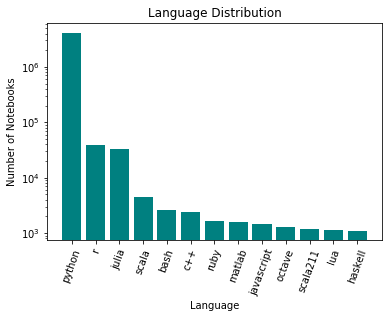

In [8]:
plot_counts = counts[counts['count'] > 1000]
x = plot_counts.lang_name
x_pos = np.arange(len(x))
height = plot_counts['count']
plt.bar(x_pos, height, color = 'teal')
plt.xticks(x_pos, x, rotation = 70)
plt.xlabel('Language')
plt.yscale('log')
plt.ylabel('Number of Notebooks')

plt.title('Language Distribution')

plt.show()

Clearly, Python is the language of choice. Python has over 100 times more notebooks than Julia or R, the next most popular languages.

## Language Use Over Time
How have relative popularities of langages canged over time?

In [9]:
def lang_over_time(language):
    start = notebooks.pushed_year.min()
    end = notebooks.pushed_year.max()
    
    language_over_time = notebooks[notebooks.lang_name == language]
    language_yearly_counts = language_over_time.groupby('pushed_year')['file'].count().reset_index().rename(columns={'file':'count'})
    to_append = {'pushed_year':[], 'count':[]}
    for y in range(start, end):
        if y not in language_yearly_counts['pushed_year'].values:
            to_append['pushed_year'].append(y)
            to_append['count'].append(0)
    to_append_df = pd.DataFrame(to_append)
    language_yearly_counts = pd.concat([language_yearly_counts, to_append_df], sort = False).sort_values(by='pushed_year')
    totals = notebooks.groupby('pushed_year')['file'].count().reset_index().rename(columns={'file':'total'})
    language_yearly_counts = language_yearly_counts.merge(totals, on = 'pushed_year')
    language_yearly_counts['language'] = language
    return language_yearly_counts

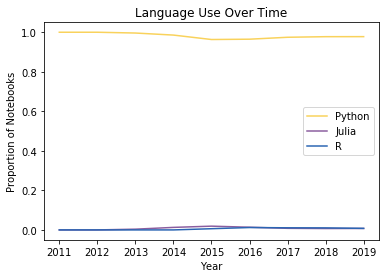

In [10]:
py_counts = lang_over_time('python')
ju_counts = lang_over_time('julia')
r_counts = lang_over_time('r')

lang_counts = pd.concat([py_counts, ju_counts, r_counts], sort = False)
lang_counts['prop'] = lang_counts['count']/lang_counts['total']

py_counts = lang_counts[lang_counts.language == 'python']
ju_counts = lang_counts[lang_counts.language == 'julia']
r_counts = lang_counts[lang_counts.language == 'r']

plt.plot(py_counts['pushed_year'],py_counts['prop'], color = '#F9D25B', label = 'Python')
plt.plot(ju_counts['pushed_year'],ju_counts['prop'], color = '#8A5D9F', label = 'Julia')
plt.plot(r_counts['pushed_year'],r_counts['prop'], color = '#2A65B3', label = 'R')

plt.title('Language Use Over Time')
plt.xlabel('Year')
plt.ylabel('Proportion of Notebooks')
plt.legend()
plt.show()


Nearly all notebooks are written in Python, and this popularity has not fluxuated that much over time. It's difficult to see the difference between Julia and R, so lets zoom in on those.

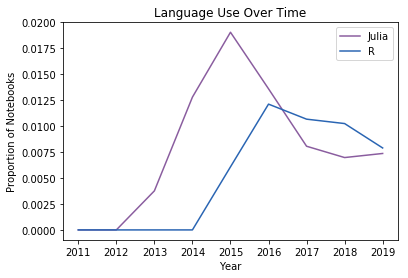

In [11]:
plt.plot(ju_counts['pushed_year'],ju_counts['prop'], color = '#8A5D9F', label = 'Julia')
plt.plot(r_counts['pushed_year'],r_counts['prop'], color = '#2A65B3', label = 'R')

plt.title('Language Use Over Time')
plt.xlabel('Year')
plt.ylabel('Proportion of Notebooks')
plt.legend()
plt.show()

Julia's popularity peaked in 2015 when it was used in around 1.8% of notebooks. Julia then became less popular and was surpassed by R in 2017. In 2019, they are at approximately equal popularities, each used in approximately 0.8% of notebooks

## Python Version Use


Release dates of python versions ([reference](https://en.wikipedia.org/wiki/History_of_Python)):
- 2.7: July 2010
- 3.3: September 2012
- 3.4: March 2014
- 3.5: September 2015
- 3.6: December 2016
- 3.7: June 2018

/home/ec2-user/anaconda3/lib/python3.5/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


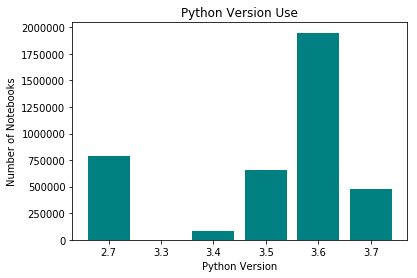

In [12]:
counts = pd.Series(notebooks.python_version[notebooks.python_version != '']).value_counts()
counts = pd.DataFrame(counts).reset_index().rename(columns={'index':'version','python_version':'counts'})
counts.version = counts.version.astype('float')
counts = counts.sort_values(by='version')
counts = counts[counts['counts'] > 50]

x = counts['version']
x_pos = np.arange(len(x))
height = counts['counts']
plt.bar(x_pos, height, color = 'teal')
plt.xticks(x_pos, x)
plt.xlabel('Python Version')
plt.ylabel('Number of Notebooks')

plt.title('Python Version Use')
plt.show()


Python 3.6 is the most common within Jupyter notebooks. Almost no notebooks were written in Python 3.3 (released September 2012) or 3.4 (March 2014).

## Why so little 3.3 and 3.4?
### Notebook formats over time and missing language version

In [13]:
format_yearly_counts = notebooks.groupby(['pushed_year','nbformat'])['file'].count().reset_index().rename(
    columns = {'file':'count'}
)

In [14]:
format_yearly_counts = format_yearly_counts.merge(
    format_yearly_counts.groupby('pushed_year')['count'].sum().reset_index().rename(
        columns = {'count':'total'}
    ),
    on = 'pushed_year'
)
format_yearly_counts['prop'] = format_yearly_counts['count']/format_yearly_counts['total']

### Proportion of notebooks in each year that were nbformat 2

In [15]:
format_yearly_counts[format_yearly_counts.nbformat == 2]

,pushed_year,nbformat,count,total,prop
0,2011,2.0,9,9,1.000000
1,2012,2.0,599,1537,0.389720
3,2013,2.0,442,8777,0.050359
5,2014,2.0,348,34582,0.010063
8,2015,2.0,220,83198,0.002644
11,2016,2.0,284,235717,0.001205
14,2017,2.0,190,641238,0.000296
17,2018,2.0,529,1423780,0.000372
20,2019,2.0,644,1786153,0.000361


### Proportion of notebooks in each year that were nbformat 3

In [16]:
format_yearly_counts[format_yearly_counts.nbformat == 3]

,pushed_year,nbformat,count,total,prop
2,2012,3.0,938,1537,0.610280
4,2013,3.0,8335,8777,0.949641
6,2014,3.0,34213,34582,0.989330
9,2015,3.0,35247,83198,0.423652
12,2016,3.0,18579,235717,0.078819
15,2017,3.0,22015,641238,0.034332
18,2018,3.0,14163,1423780,0.009947
21,2019,3.0,11056,1786153,0.006190


In [17]:
print("{0}% of nbformat 2 python notebooks have missing language version".format(
    round(100*sum(notebooks[
        np.logical_and(notebooks.nbformat == 2, notebooks.lang_name == 'python')
    ].lang_version.isna()) / len(
        notebooks[np.logical_and(notebooks.nbformat == 2, notebooks.lang_name == 'python')]
    ), 2)
))

print("{0}% of nbformat 3 python notebooks have missing language version".format(
    round(100*sum(notebooks[
        np.logical_and(notebooks.nbformat == 3, notebooks.lang_name == 'python')
    ].lang_version.isna()) / len(
        notebooks[np.logical_and(notebooks.nbformat == 3, notebooks.lang_name == 'python')]
    ), 2)
))

print("{0}% of nbformat 4 python notebooks have missing language version".format(
    round(100*sum(notebooks[
        np.logical_and(notebooks.nbformat == 4, notebooks.lang_name == 'python')
    ].lang_version.isna()) / len(
        notebooks[np.logical_and(notebooks.nbformat == 4, notebooks.lang_name == 'python')]
    ), 2)
))

99.6% of nbformat 2 python notebooks have missing language version
98.33% of nbformat 3 python notebooks have missing language version
0.31% of nbformat 4 python notebooks have missing language version


Only 0.32% of nbformat 4 notebooks have a missing language version. However, *98.2%* of nbformat 3 notebooks and *99.6%* of nbformat 2 notbooks are mising language version. Further, nbformat 2 notebooks were prominent from 2011 to 2012, and nbformat 3 notebooks from 2012 to 2015. These years overlab with the releases of Python 3.3 and 3.4, when they were new and likely used a lot.

Visually inspecting some nbformat 3 notebooks, there is a place in the json where language_version *should* be, but is only actually there and found 1.7% of the time. It's highly unlikely that Python 3.3 and 3.4 are actually as unpopular as shown above.

## Version use over time
***Keep in mind that counts are likely missing for python 3.3 and 3.4!***

In [18]:
start = datetime.datetime.now()

yearly_version_counts = notebooks[notebooks['lang_name']=='python'].groupby(['pushed_year', 'python_version'])['file']\
    .count().reset_index().rename(columns={'file':'count'})
yearly_totals = yearly_version_counts.groupby('pushed_year')[['count']].sum().reset_index().rename(columns={'count':'total'})
yearly_version_counts = yearly_version_counts.merge(yearly_totals, on = 'pushed_year')
yearly_version_counts['prop'] = yearly_version_counts['count']/yearly_version_counts['total']

end = datetime.datetime.now()
print(end - start)

0:00:01.641883


In [19]:
start_time = datetime.datetime.now()

all_counts = []
start = yearly_version_counts.pushed_year.min()
end = yearly_version_counts.pushed_year.max()

# fill in zeros
for version in [2.7, 3.4, 3.5, 3.6, 3.7]:
    version_counts = yearly_version_counts.copy()[yearly_version_counts['python_version']==version]
    to_append = {'pushed_year':[], 'count': [], 'prop':[], 'version':[]}
    for year in range(start,end):
        if year not in version_counts['pushed_year'].values:
            to_append['pushed_year'].append(year)
            to_append['count'].append(0)
            to_append['prop'].append(0)
            to_append['version'].append(version)
    to_append_df = pd.DataFrame(to_append)            
    if len(to_append_df) > 0:
        version_counts = pd.concat(
            [version_counts, to_append_df], sort = False
        ).sort_values(by='pushed_year')
    version_counts['version'] = [version]*len(version_counts)
    all_counts.append(version_counts)
    
end_time = datetime.datetime.now()
print(end_time - start_time)

0:00:00.023200


Plot Python versions over time, yearly and then monthly

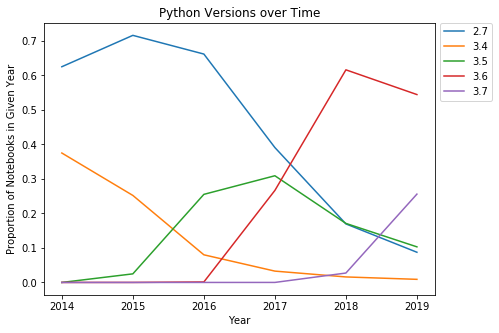

In [20]:
fig = plt.figure(figsize = (7, 5))
for version in all_counts:
    plt.plot(
        version.pushed_year, version.prop, 
        label = version.version.iloc[0],
    )

plt.xlabel('Year')
plt.ylabel('Proportion of Notebooks in Given Year')
plt.title('Python Versions over Time')
plt.legend(bbox_to_anchor=(1.16, 1.02))
plt.show()

[Notebook Popularity &lt;](1_Popularity.ipynb) | [&gt; Notebook Owners](3_Owners.ipynb)